## <center> Compression Factor </center>

This notebook contains a small experimental validation of the role played by Compression factor. We create a toy dataset based on sampling random points from a unit circle split into two classes. Based on the classes, we compress our embeddings such that samples from the same class appear to be very close in the original space, and samples from dissimilar classes appear farther apart in the orginal space. 

<center>
<img src="https://drive.google.com/uc?id=1-btjQParAQciNJBlqp90LgLJgd1isGUo" alt="CompressionFactor"
	title="Compression Factor" width="480" />
</center>

## Part 1: Installations

Install required libraries in a new virtual environment.<br>
Skip this step if you have already created a virtual environment for LEt-SNE.

In [1]:
# If using with Google Colab, restart the runtime if prompted
# Resetting the runtime ensures correct version of a library is selected
!sudo apt-get update
!sudo apt install python3-venv libnvidia-common-430 unrar               # Needed if using Google Colab
!python3 -m venv LEt-SNE_environment                            # Create a new environment and activate it 
!source LEt-SNE_environment/bin/activate; pip install -r LEt-SNE_requirements.txt

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ Packages [88.1 kB]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Hit:11 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:13 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [44.6 kB]
Get:14 http://ppa.launchpad.net/marutter/c2d4u3.5/ubun

## Part 2: Experimental setup

Import the required libraries with some tweaks to ensure aesthetic appearance of our plots. Defining helper functions and LEt-SNE.

In [2]:
# If using with Google Colab, set TensorFlow to version 1.x
%tensorflow_version 1.x

import os
import random
import warnings

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.contrib.layers import l2_regularizer as l2_reg

# allow growth = True eliminates TF 1.13 cuDNN error
if tf.__version__[:4] == '1.13':
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
else:
    config = None

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [15/2.54, 15/2.54]
plt.rcParams['figure.dpi'] = 150

TensorFlow 1.x selected.


Setting up the directory of TensorBoard for Compression Factor

In [0]:
# Setting the seed to a fixed value for reproducibility purpose
# Based on https://medium.com/@ODSC/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752
seed_value = 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.set_random_seed(seed_value)

# Location of current file
FILE_DIR = os.path.dirname(os.path.abspath("__file__"))
TENSORBOARD_DIR = os.path.join(FILE_DIR, 'TensorBoard_CF')

os.mkdir(TENSORBOARD_DIR)

# Setting runtime options
np.set_printoptions(threshold=np.inf)                            # To print all elements of np array without truncation
tf.logging.set_verbosity(tf.logging.INFO)
warnings.simplefilter(action='ignore', category=FutureWarning)

Defining experiment configurations

In [0]:
LABEL = True                         # Either MANIFOLD = True or LABEL = True or SEGMENTATION = True
MANIFOLD = False
SEGMENTATION = False

NUM_BANDS = 2                        # Dimensionality of our original data
NUM_CLASSES = 2                      # The dataset will contain two classes
NUM_EPOCHS = 500                     # Training epochs. One epoch is passing all training data through the model

# Inverted t-SNE
PERPLEXITY = 45                      # A soft measure of the number of neighbours for a sample. High variance, high perp
TOLERANCE = 0.1                      # Acceptable deviation from the perplexity
COMPRESSION_FACTOR = 50              # Multiplicative factor to boost probabilities of samples having same class

# Model Parameters
BATCH_SIZE = 1024
DIM_REDUCED = 2
HIDDEN = [DIM_REDUCED]               # If single element list, convolutional layers flattened to produce encoding
LOSS_REGULARIZATION = 0.0
LEARNING_RATE = 0.0001

# Laplacian
NUM_NEIGHBOURS = 0                   
# = BATCH_SIZE // (5 * NUM_CLASSES), Updated if MANIFOLD == True in load_data()
# = 0, SEGMENTATION OR LABEL uses segmented regions/labels to compute adjacency

LOSS_WEIGHTS = np.array([0.05, 1.0, 0.0], dtype=np.float32)
# Laplacian, inv_tSNE = 1 (SEG, LAB) = 5 (MANIFOLD),  Reconstruction, CAE, Encoding Norm Constraint

# Global constants for the purpose of debugging
LOG_TENSOR = [False, False, False, False]     # Debug: Graph_Adjacency, Perplexity, Embedding pairwise l2norm, embedding
LOG_TENSOR_DICT = {}                          # Will contain various attributes to log

Defining a function to convert dataset into TensorFlow compatible format

In [0]:
def dataset_tf(bands, labels, train=True):
    '''
    TENSORFLOW
    Creates a TensorFlow dataset object which is given as input to the Estimator object
    Converts the labels into one-hot encoded targets.
    :param bands: 2D array (numpy) of hyperspectral image bands
    :param labels: 1D array (numpy) of labels corresponding to bands
    :param train: boolean (True) If true, dataset repeats for NUM_EPOCHS, no repeatation otherwise (prediction phase)
    :return: TensorFlow Dataset object
    '''

    with tf.variable_scope("Dataset_Batches"):
        # Dataset dimensions should be (NUM_BANDS, 1) as tf.layers.conv1d() requires channel depth to be known
        # Labels are converted to one_hot inside classification_loss (LEt_SNE function)
        band_dataset = tf.data.Dataset.from_tensor_slices((bands, labels)).map(lambda x, y: (tf.reshape(x, (-1, 1)), y))
        if train:
            band_dataset = band_dataset.shuffle(100000).repeat(NUM_EPOCHS).batch(BATCH_SIZE, drop_remainder=True)
        else:
            band_dataset = band_dataset.batch(BATCH_SIZE)
        tf.logging.info('Batches created')
        tf.logging.info('1. Dataset element \nType: %s \nShape: %s',
                        str(band_dataset.output_types),
                        str(band_dataset.output_shapes))
        return band_dataset

We define the LEt-SNE model

In [0]:
def let_sne(features, labels, mode, params):
    '''
    TENSORFLOW
    This acts as model function which is provided to object of Estimator class
    The model consists of an autoencoder and a LINEAR classification branch, which
    originates from the hidden layer representation. We include a linear branch
    to guide the network to learn linearly separable lower dimensional representation
    of the input space. Thus, class labels are used to learn encoding of the bands.
    :param features: A 2D tensor of size [BATCH_SIZE, NUM_BANDS]; input to the network
    :param labels: A 2D tensor of size [BATCH_SIZE, NUM_CLASSES]; one-hot representation of the labels
    :param mode: (tf.keys) Predict, Evaluate, Train. Value depends on the keys passed to the estimator
    :param params: Dictionary, consisting of the number of hidden nodes, and the ratio of the losses
    :return: tf.estimator.EstimatorSpec() object, return value depends on the ModeKeys used to call the estimator.
    '''

    def model(input_features, bn_train):
        '''
        1-D convolutional autoencoder with weight regularization for the decoder and classification layers.
        :param input_features: A 3D tensor of size [BATCH_SIZE, NUM_BANDS, 1]; input to the network
        :return: 1. encoder: A 2D tensor of size [BATCH_SIZE, DIM_REDUCED]; lower dimension encoding of data
                 2. decoder: A 2D tensor of size [BATCH_SIZE, NUM_BANDS]; reconstruction from the encoder_bands
                 3. weights_encoder: A 2D tensor of size [HIDDEN[0] , HIDDEN[1]], linear mapping to the embedding
        '''

        with tf.variable_scope("LEt_SNE"):
            # We do not use convolutional features to provide a fair comparison with other approaches.
            # However, convolutional feature extraction should provide superior results over the Fully Connected variant
            input_features_flat = tf.layers.Flatten()(input_features)
            encoder_mid = tf.layers.Dense(units=64, activation=None,
                                          name='encoder_mid')(input_features_flat)
            batch_norm_1 = tf.nn.relu(tf.layers.batch_normalization(inputs=encoder_mid, momentum=0.99, epsilon=1e-5,
                                                                    name="batch_norm_1", training=bn_train))
            encoder = tf.layers.Dense(units=params['hidden'][0], activation=None,
                                      name='encoder')(batch_norm_1)

        with tf.variable_scope("LEt_SNE/Reconstruction"):
            # Decoder network
            decoder_mid = tf.nn.relu(tf.layers.Dense(units=64,
                                                     name='decoder_mid',
                                                     kernel_regularizer=l2_reg(scale=LOSS_REGULARIZATION))(encoder))
            decoder = tf.layers.Dense(units=NUM_BANDS,
                                      name='decoder',
                                      kernel_regularizer=l2_reg(scale=LOSS_REGULARIZATION))(decoder_mid)

        graph = tf.get_default_graph()
        p = graph.get_operations()
        tf.logging.debug('\nGlobal Variables: ' + str(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)))
        tf.logging.debug("Graph operations: " + str(p[-1].values()) + "\n")
        tf.summary.histogram('encoder', graph.get_tensor_by_name('LEt_SNE/encoder/kernel:0'))
        tf.summary.histogram('decoder', graph.get_tensor_by_name('LEt_SNE/Reconstruction/decoder/kernel:0'))

        # Plot the l2-norm for debugging purposes
        encode_tensor = graph.get_tensor_by_name('LEt_SNE/encoder/BiasAdd:0')
        encode_l2_norm = tf.reduce_mean(tf.norm(encode_tensor, ord='euclidean', axis=1))
        tf.summary.scalar('Encoding_l2_norm', encode_l2_norm)
        if params['convolution']:
            batch_norm_2_tensor = graph.get_tensor_by_name('LEt_SNE/batch_norm_2/batchnorm/add_1:0')
            bn_2_l2_norm = tf.reduce_mean(tf.norm(batch_norm_2_tensor, ord='euclidean', axis=1))
            tf.summary.scalar('BatchNorm_2_l2_norm', bn_2_l2_norm)

        weights_encoder = graph.get_tensor_by_name('LEt_SNE/encoder/kernel:0')

        return encoder, decoder, weights_encoder

    def graph_distance(input_features):
        '''
        Computes the pairwise SQUARED distance between 2 samples in the mini-batch.
        This is given by D[i,j] = (a[i]-a[j])(a[i]-a[j])', which simplifies to D = r - 2 A A' + r' in the matrix form.
        Similar to https://stackoverflow.com/a/37040451
        :return: (BATCH_SIZE x BATCH_SIZE) Tensor containing pairwise distance between the samples.
        '''
        # Similar to https://stackoverflow.com/a/37040451
        with tf.name_scope("Graph_Distance"):

            input_features = tf.layers.Flatten()(input_features)
            feature_square_l2 = tf.reduce_sum(input_features * input_features, 1)
            feature_square_l2 = tf.reshape(feature_square_l2, [-1, 1])
            feature = tf.reshape(input_features, [BATCH_SIZE, -1])
            dist = feature_square_l2 - (2 * tf.matmul(feature, tf.transpose(feature))) + tf.transpose(feature_square_l2)

            return dist

    def permutation(indices):
        '''
        Genrates all possible input permutations, taken two at a time: nP2
        :param indices: 1D Tensor, contains indices of samples having same class
        :return: 2D Tensor, returns permutations.
        '''
        with tf.name_scope('Permutation'):
            # Similar to https://stackoverflow.com/a/48225468
            tile_a = tf.tile(tf.expand_dims(indices, 1), [1, tf.shape(indices)[0]])
            tile_a = tf.expand_dims(tile_a, 2)
            tile_b = tf.tile(tf.expand_dims(indices, 0), [tf.shape(indices)[0], 1])
            tile_b = tf.expand_dims(tile_b, 2)
            cart = tf.concat([tile_a, tile_b], axis=2)
            cart = tf.reshape(cart, [-1, 2])
            return cart

    def graph_adjacency(input_features):
        '''
        Computes the adjacency matrix of the graph by connecting the K Nearest neighbours to the sample.
        The adjacency matrix is symmetric in nature, computes element-wise maximum of Adj_Matrix and Adj_Matrix_T
        :param input_features: (3D Tensor) input to the model
        :return: (BATCH_SIZE x BATCH_SIZE) Tensor which is the Adjacency matrix
        '''
        with tf.name_scope("Adjacency"):
            if NUM_NEIGHBOURS:
                # Compute adjacency using euclidean nearest neigbours
                tf.logging.info("Computing Graph Laplacian using k-Nearest Neighbours")
                distance_matrix = graph_distance(input_features)

                # Similar to https://stackoverflow.com/a/49966843
                values, index = tf.math.top_k(input=(-1 * distance_matrix), k=(NUM_NEIGHBOURS + 1), sorted=True)
                index_one_hot = tf.one_hot(index, depth=BATCH_SIZE)
                index_reduced = tf.reduce_sum(index_one_hot, axis=-2)
                index = tf.where(tf.not_equal(index_reduced, 0))

                adjacency_matrix = tf.scatter_nd(indices=index,
                                                 updates=tf.ones([(NUM_NEIGHBOURS + 1) * BATCH_SIZE]),
                                                 shape=(BATCH_SIZE, BATCH_SIZE),
                                                 name='Graph_Adjacency_kNN')

                return tf.maximum(adjacency_matrix, tf.transpose(adjacency_matrix))

            else:
                # Compute adjacency using LABEL or SEGMENTATION information
                tf.logging.info("Computing Graph Laplacian using class labels")

                # We split up the labels into segments, each having the same label
                graph_labels = tf.reshape(labels, [-1])
                graph_index = tf.argsort(graph_labels, axis=0)
                graph_labels_sort = tf.sort(graph_labels)
                _, __, graph_count = tf.unique_with_counts(graph_labels_sort)
                # There is a small chance that the mini batch may have some classes absent.
                # Since TensorFlow has static graph, we pad the missing classes with '0'.
                # NOTE: We do not know which classes are missing. Our algorithm splits labels having same class.
                if SEGMENTATION:
                    padding = tf.constant(NUM_REGIONS) - tf.shape(graph_count)[0]
                else:
                    assert LABEL, "Segmentation and Label both are False"
                    padding = tf.constant(NUM_CLASSES) - tf.shape(graph_count)[0]
                count_pad = tf.pad(graph_count, [[0, padding]])
                # Split_indices returns a list containing Tensors, thus we can use python map, since we are mapping
                # elements of list to function, and not elements of tensor to function.
                if SEGMENTATION:
                    split_indices = tf.split(graph_index, count_pad, num=NUM_REGIONS)
                else:
                    split_indices = tf.split(graph_index, count_pad, num=NUM_CLASSES)

                # Label argmax are split into tensors of indices having same class.
                # Generate nP2 combinations of indices that denote pointers in the adjacency matrix; which are connected
                graph_connected_indices = list(map(permutation, split_indices))
                graph_connected_indices = tf.concat(graph_connected_indices, axis=0)
                # The shape of graph_connected_indices will defer from batch to batch; which isn't allowed in TensorFlow
                # Eg: Batch having one class: shape = BATCH_SIZE ** 2
                #     Batch having two class (equal): shape = 2(((BATCH_SIZE) / 2) ** 2)
                # Thus we pad this tensor by BATCH_SIZE ** 2 (which is max possible length of the tensor)and truncate it
                # Value for padding is chosen as BATCH_SIZE
                graph_connected_indices = tf.pad(tensor=graph_connected_indices,
                                                 paddings=[[0, (BATCH_SIZE ** 2)], [0, 0]],
                                                 constant_values=BATCH_SIZE)  # pad along rows
                graph_connected_indices = graph_connected_indices[:(BATCH_SIZE ** 2), :]

                adjacency_matrix = tf.scatter_nd(indices=graph_connected_indices,
                                                 updates=tf.ones([BATCH_SIZE ** 2]),
                                                 shape=(BATCH_SIZE + 1, BATCH_SIZE + 1),
                                                 name='Graph_Adjacency_Classes')
                corrected_adjacency = adjacency_matrix[:BATCH_SIZE, :BATCH_SIZE]

                if LOG_TENSOR[0]:
                    global LOG_TENSOR_DICT
                    LOG_TENSOR_DICT["Graph_Adjacency"] = corrected_adjacency

                return corrected_adjacency

    def graph_laplacian(input_features):
        '''
        Computes the Graph Laplacian L = D - A where L is the Laplacian, D is the degree of the graph, A is adjacency
        :param input_features: (3D Tensor) input to the model
        :return: (BATCH_SIZE x BATCH_SIZE) Tensor which is the Laplacian matrix
        '''
        with tf.variable_scope("Laplacian", reuse=False):
            adjacency = graph_adjacency(input_features)
            degree = tf.linalg.diag(tf.reduce_sum(adjacency, -1))
            laplacian = degree - adjacency

            adjacency = tf.stop_gradient(adjacency)
            degree = tf.stop_gradient(degree)
            laplacian = tf.stop_gradient(laplacian)

            return laplacian, degree, adjacency

    def kl_divergence(num, den):
        '''
        Computes the KL divergence between two distributions A and B
        :param a: 2D-Tensor; First probability distribution
        :param b: 2D-Tensor; Second probability distribution
        :return: Scalar; The KL divergence between a and b
        '''
        kl = tf.math.reduce_sum(tf.multiply(num, tf.log(tf.divide(num, den))))
        return kl

    def shannon_entropy(probs_array):
        '''
        Computes the Shannon Entropy for a distribution
        :param probs_array: 2D-Tensor; Probability distribution along axis=1
        :return: Scalar; H(p)
        '''
        h_shannon = tf.cast(tf.reduce_sum(-probs_array * (tf.log(probs_array)), axis=1), dtype=tf.float32)
        return h_shannon

    def js_divergence(probs_array):
        '''
        Computes the JS divergence between the compressed representation of the neurons
        Our goal is to maximize the divergence causing every neuron to encode
        different information from the rest.
        :param probs_array: (BARCH_SIZE x DIM_REDUCED) representation of hidden neurons
        :return: Scalar; JS divergence between the bands
        '''
        # Convert them to probability values, all elements in P_array are +ve due to sigmoid activation
        normalizer = tf.reduce_sum(probs_array, axis=0)
        probs_normalized = probs_array / normalizer

        probs_mean = tf.reduce_mean(probs_normalized, axis=1)

        # Index to access individual neurons in the hidden layer
        i = tf.constant(0)
        # Tensor to store the accumulated value of individual hidden neuron entropy
        entropy_sum = tf.constant(0.0, dtype=tf.float32)

        # Iterate over all the hidden bands
        def loop_condition(i, entropy_sum):
            return tf.less(i, DIM_REDUCED)

        # Parallel accumulation of individual band entropy into entropy_sum
        def loop_body(i, entropy_sum):
            entropy_sum = entropy_sum + shannon_entropy(probs_normalized[:, i])
            return i + 1, entropy_sum

        _, entropy_sum_while = tf.while_loop(loop_condition, loop_body, [i, entropy_sum], back_prop=True)
        js = shannon_entropy(probs_mean) - (entropy_sum_while / DIM_REDUCED)
        return js

    def p_conditional(pairwise_dist, adjacency):
        '''
        Computes P(j|i) using Binary Search
        :param pairwise_dist: (2D Tensor) pairwise distances between samples
        :return: 2D Tensor containing conditional probabilities
        '''
        # Estimating P i|j in the original space
        with tf.variable_scope('P_ij_conditional'):
            lower = tf.zeros([BATCH_SIZE])
            upper = 500 * tf.ones([BATCH_SIZE])
            pair_dist_neg = -pairwise_dist
            perplexity = PERPLEXITY * tf.ones([BATCH_SIZE])

            def calc_probs_perp(lower_bound, upper_bound):
                with tf.variable_scope('t-SNE/calc_perplexity'):
                    # Binary search
                    sigmas = (lower_bound + upper_bound) / 2
                    variance = tf.reshape(tf.square(sigmas), [-1, 1])
                    scaled_pair_dist_neg = tf.divide(pair_dist_neg, 2 * variance)
                    probs_unnormalized = tf.math.exp(scaled_pair_dist_neg)

                    # probability of point choosing itself as neighbour ~ 0
                    probs_unnormalized = tf.matrix_set_diag(probs_unnormalized, tf.zeros([BATCH_SIZE]))
                    softmax = tf.divide(probs_unnormalized, tf.reduce_sum(probs_unnormalized, axis=1, keepdims=True))

                    # clipping to avoid NaN values during entropy computation
                    softmax_clip = tf.clip_by_value(softmax, clip_value_min=1e-15, clip_value_max=1.)

                    entropy = shannon_entropy(softmax_clip)
                    perplexity_hat = tf.math.pow(2 * tf.ones([BATCH_SIZE]), entropy)

                    return perplexity_hat, softmax_clip

            perplexity_initial, probs = calc_probs_perp(lower, upper)

            def cond(_, __, perplexity_hat, ___):
                mask = tf.math.less(tf.abs(perplexity_hat - perplexity), TOLERANCE * tf.ones([BATCH_SIZE]))
                return tf.math.logical_not(tf.reduce_all(mask))

            def body(upper, lower, estimate_perplexity, _):
                # tf.cast(): True --> 1    False --> 0
                mask_gt = tf.math.greater(estimate_perplexity, perplexity)
                mask_gt = tf.cast(mask_gt, tf.float32)
                upper_update = upper - tf.multiply(mask_gt, (upper - lower) / 2)

                mask_lt = tf.math.less(estimate_perplexity, perplexity)
                mask_lt = tf.cast(mask_lt, tf.float32)
                lower_update = lower + tf.multiply(mask_lt, (upper - lower) / 2)

                upper = upper_update
                lower = lower_update

                perplexity_hat, probs = calc_probs_perp(lower, upper)

                return upper, lower, perplexity_hat, probs

            # Keeps computing till all values converge with the tolerance limit for perplexity or max iter reached
            lower_bound, upper_bound, perplexity_hat, probs_while = tf.while_loop(cond=cond,
                                                                                  body=body,
                                                                                  loop_vars=(upper,
                                                                                             lower,
                                                                                             perplexity_initial,
                                                                                             probs),
                                                                                  parallel_iterations=1,
                                                                                  maximum_iterations=1000)

            if LOG_TENSOR[1]:
                global LOG_TENSOR_DICT
                LOG_TENSOR_DICT["Perplexity"] = perplexity_hat

            # Compressing space around a point by boosting probability values of neighbours having same class
            if COMPRESSION_FACTOR != 1:
                probs_while = tf.matrix_set_diag(probs_while, tf.zeros([BATCH_SIZE]))
                probs_while = tf.multiply(probs_while, ((COMPRESSION_FACTOR - 1) * adjacency) + 1)
                probs_while = tf.divide(probs_while, tf.reduce_sum(probs_while, axis=1, keepdims=True))
                probs_while = tf.clip_by_value(probs_while, clip_value_min=1e-15, clip_value_max=1.)
            probs_while = tf.stop_gradient(probs_while)
            return probs_while

    def q_conditional(pairwise_dist, cauchy_dist=True, gaussian_dist=False):
        '''
        Computes Q(j|i) using Binary Search
        :param pairwise_dist: (2D Tensor) pairwise distances between samples
        :return: 2D Tensor containing conditional probabilities
        '''
        # Estimating Q i|j in the latent space
        with tf.variable_scope('Q_ij_conditional'):
            if cauchy_dist:
                cauchy = 1 + pairwise_dist
                cauchy = tf.math.pow(x=cauchy, y=(-1 * tf.ones([BATCH_SIZE, BATCH_SIZE])))
                cauchy = tf.matrix_set_diag(cauchy, tf.zeros([BATCH_SIZE]))
                cauchy = tf.divide(cauchy, tf.reduce_sum(cauchy, axis=1, keepdims=True))
                cauchy_clip = tf.clip_by_value(cauchy, clip_value_min=1e-15, clip_value_max=1.)
                return cauchy_clip

            if gaussian_dist:
                pair_dist_neg = -pairwise_dist
                variance = 1 * tf.ones(shape=[BATCH_SIZE, 1])
                scaled_pair_dist_neg = tf.divide(pair_dist_neg, 2 * variance)
                probs_unnormalized = tf.math.exp(scaled_pair_dist_neg)

                # probability of point choosing itself as neighbour ~ 0
                probs_unnormalized = tf.matrix_set_diag(probs_unnormalized, tf.zeros([BATCH_SIZE]))
                softmax = tf.divide(probs_unnormalized, tf.reduce_sum(probs_unnormalized, axis=1, keepdims=True))

                # clipping to avoid NaN values during entropy computation
                softmax_clip = tf.clip_by_value(softmax, clip_value_min=1e-15, clip_value_max=1.)
                return softmax_clip

    def inv_tsne(input_features, embedding, adjacency):
        '''
        KL(p||q) for manifold, KL(q|p) for segmentation + labelling
        :param input_features: (3D Tensor) input batch
        :param embedding: (3D Tensor) network output
        :param adjacency: (2D Tensor) Adjacency map
        :return: (scalar Tensor) KL Divergence
        '''
        # Eliminates extra dimension introduced by Conv1D
        # input_features = tf.layers.Flatten()(input_features)

        # Computes the pairwise distance between samples in the original and reduced space
        input_l2_pair = graph_distance(input_features)
        embedding_l2_pair = graph_distance(embedding)

        if LOG_TENSOR[2]:
            global LOG_TENSOR_DICT
            LOG_TENSOR_DICT["Embedding_l2_pair"] = embedding_l2_pair

        probs_p = p_conditional(tf.cast(input_l2_pair, dtype=tf.float32), adjacency)
        probs_q = q_conditional(embedding_l2_pair, cauchy_dist=True)

        if MANIFOLD:
            kl_p_q = kl_divergence(num=probs_p, den=probs_q)
            return kl_p_q
        else:
            kl_q_p = kl_divergence(num=probs_q, den=probs_p)
            return kl_q_p

    if mode == tf.estimator.ModeKeys.TRAIN:
        (embedding, reconstruction, weights_encoder) = model(input_features=features, bn_train=True)
    else:
        (embedding, reconstruction, weights_encoder) = model(input_features=features, bn_train=False)

    # Compute predictions.
    with tf.variable_scope("LEt_SNE/Prediction"):
        if mode == tf.estimator.ModeKeys.PREDICT:
            predictions = {'encoded': embedding}

            return tf.estimator.EstimatorSpec(mode, predictions=predictions)

    with tf.variable_scope("LEt_SNE/Losses"):

        embedding = tf.cast(embedding, dtype=tf.float32)

        # Loss as defined by the Laplacian Eigenmaps
        laplacian, degree, adjacency = graph_laplacian(input_features=features)
        loss_laplacian = tf.trace(tf.matmul(tf.matmul(tf.transpose(embedding), laplacian), embedding))

        # Loss for Reconstruction (Autoencoder)
        loss_reconstruction = tf.cast(
            tf.losses.mean_squared_error(labels=features,
                                         predictions=tf.reshape(reconstruction, [-1, NUM_BANDS, 1]),
                                         reduction=tf.losses.Reduction.SUM),
            dtype=tf.float32)

        # Modified t-SNE loss
        loss_inv_tsne = inv_tsne(features, embedding, adjacency)

        total_loss = tf.convert_to_tensor([loss_laplacian, loss_inv_tsne, loss_reconstruction])

        if LOG_TENSOR[3]:
            global LOG_TENSOR_DICT
            LOG_TENSOR_DICT["Encoding"] = embedding

        tf.summary.scalar('Laplacian_loss', loss_laplacian * params['loss_weights'][0])
        tf.summary.scalar('Inverse_tSNE_loss', loss_inv_tsne * params['loss_weights'][1])
        tf.summary.scalar('Reconstruction_loss', loss_reconstruction * params['loss_weights'][2])

    with tf.variable_scope("LEt_SNE/Train"):
        optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE, name='Adam')
        loss = tf.reduce_sum(tf.multiply(params['loss_weights'], total_loss))
        train = optimizer.minimize(loss=loss,
                                   global_step=tf.train.get_or_create_global_step(),
                                   name='Adam_minimizer')
        if mode == tf.estimator.ModeKeys.TRAIN:
            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            with tf.control_dependencies(update_ops):
                loss = tf.identity(loss)
            if True in LOG_TENSOR:
                logging_hook = tf.train.LoggingTensorHook(LOG_TENSOR_DICT, every_n_iter=500)
                return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train, training_hooks=[logging_hook])
            else:
                return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train)


We define a new function to obtain predictions from LEt-SNE custom estimator

In [0]:
def predictor(bands, labels, model, type):
    '''
    NUMPY AND TENSORFLOW
    '''
    assert type == 'encoded', "Choose valid Prediction"
    generator = model.predict(input_fn=lambda: dataset_tf(bands, labels, train=False))
    prediction = np.empty(shape=(0, DIM_REDUCED), dtype=np.float32)
    while True:
        try:
            prediction = np.append(prediction,
                                   np.reshape(next(generator)[type], [1, -1]),
                                   axis=0)
        except StopIteration:
            break
    assert prediction.shape[0] == bands.shape[0], "Predictions not present for all bands"
    return prediction


## Part 3: Creating the Dataset 

We simulate a two-class dataset drawn from the equation of a circle

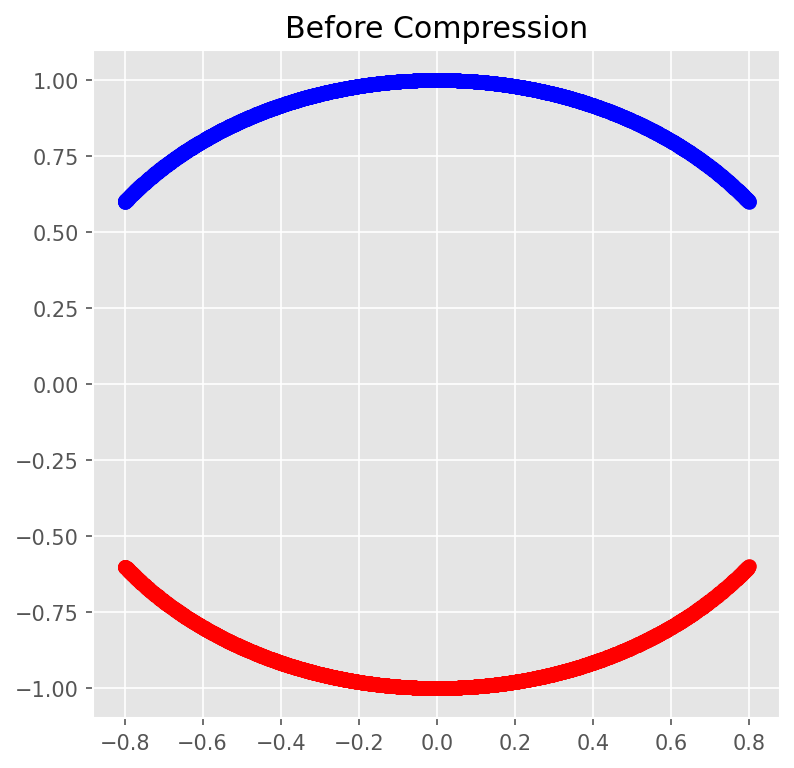

In [8]:
def artificial_dataset():
    '''

    :return:
    '''
    import logging
    global NUM_BANDS, NUM_CLASSES
    NUM_BANDS = 2
    NUM_CLASSES = 2

    positive_class = []
    negative_class = []

    @np.vectorize
    def circle(x):
        return np.sqrt(1 - (x**2))

    x_range = np.arange(-0.8, 0.800001, 0.000001)

    # Positive Class
    x = np.random.choice(a=x_range, size=10000)
    positive_x = x[:5000]
    negative_x = x[5000:]

    positive_y = circle(positive_x)
    negative_y = -circle(negative_x)

    labels = np.concatenate([np.ones(5000), np.zeros(5000)], axis=0).reshape(-1, 1)
    y = np.concatenate([positive_y, negative_y]).reshape(-1, 1)
    x = x.reshape(-1, 1)

    dataset = np.concatenate([x, y, labels], axis=-1)

    color=['r', 'b']

    for label in [0, 1]:
        indices = np.where(dataset[:, -1] == label)
        x = dataset[indices, 0]
        y = dataset[indices, 1]
        plt.plot(x, y, marker='o', linestyle="", c=color[label])
        plt.title('Before Compression')

    plt.show()
    return dataset[:, :2], dataset[:, 2]

train_data, train_label = artificial_dataset()
train_label = train_label.astype(np.int32)

## Part 4: Training LEt-SNE

In [9]:
let_sne_ = tf.estimator.Estimator(model_fn=let_sne,
                                  model_dir=os.path.join(TENSORBOARD_DIR, 'LEt_SNE'),
                                  config=tf.estimator.RunConfig(session_config=config,
                                                                keep_checkpoint_max=20),
                                  params={'hidden': HIDDEN,
                                          'loss_weights': LOSS_WEIGHTS,
                                          'convolution': False})
let_sne_.train(input_fn=lambda: dataset_tf(train_data, train_label, train=True))

INFO:tensorflow:Using config: {'_model_dir': '/content/TensorBoard_CF/LEt_SNE', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 20, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb4aa455400>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initi

## Part 5: Evaluating embeddings

In [10]:
# It does't matter what labels you provide for prediction, since graph pertaining to loss is not executed
train_encoding = predictor(train_data, train_label, let_sne_, 'encoded')

labels = np.concatenate([np.ones(5000), np.zeros(5000)], axis=0).reshape(-1, 1)
dataset = np.concatenate([train_encoding, labels], axis=-1)

INFO:tensorflow:Batches created
INFO:tensorflow:1. Dataset element 
Type: (tf.float64, tf.int32) 
Shape: (TensorShape([Dimension(None), Dimension(2), Dimension(1)]), TensorShape([Dimension(None)]))
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /content/TensorBoard_CF/LEt_SNE/model.ckpt-4882
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


## Part 6: Visualizing the embeddings

Note the clustering of samples in the embeddings. Also, the scale of the original and embedded samples is different, implying a greater separation between dissimilar classes.

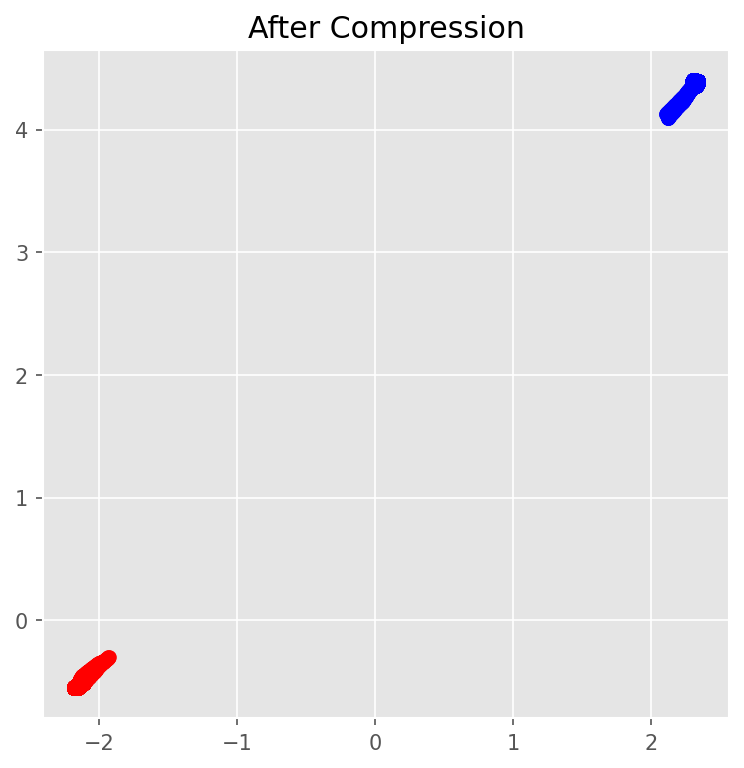

In [11]:
color = ['r', 'b']

for label in [0, 1]:
    indices = np.where(dataset[:, -1] == label)
    x = dataset[indices, 0]
    y = dataset[indices, 1]
    plt.plot(x, y, marker='o', linestyle="", c=color[label])
    plt.title('After Compression')

plt.show()